In [ ]:
!pip install tensorflow==2.6.0
!pip install Cython==0.29.24
!pip install numpy==1.19.5
!pip install matplotlib==3.2.2 
!pip install seaborn==0.11.2 
!pip install scipy==1.4.1 
!pip install scikit-learn==0.22.2.post1 
!pip install scikit-image==0.16.2 
!pip install pandas==1.1.5 
!pip install pyyaml 
!pip install imutilstqdm==4.62.3 
!pip install psutil==5.4.8 
!pip install h5py==3.1.0

     |████████████████████████████████| 458.3 MB 8.3 kB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30692 sha256=83fe8281f8a907a31a70f3992e20ce22f0063cd6b3d8383fb7888c5f6346e599
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68705 sha256=1ce955bade339eeeeda2bae272a77ef6c58c267fff2f9d50c3fbd84f91d05148
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built clang wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.13.3
    Uninstalling wrapt-1.13.3:
      Successfully uninstalled wrapt-1.13.3
  Attempting uninstall: flatbuffer

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

%matplotlib inline

In [2]:
onColab = True
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE2
  !ls

Mounted at /gdrive
/gdrive/MyDrive/University/ANN/CHALLENGE2
analysis.ipynb			 multimodel_1
baseline			 multimodel_2
baseline_2			 multi_model_2.ipynb
baseline_2_ckpt			 multi_model.ipynb
baseline_3			 multimodel_model.ipynb
baseline_3_ckpt			 multimodel_with_baseline
baseline_3_forSub		 multimodel_with_baseline_2
baseline_3_training_smooth	 multimodel_with_baseline_3
baseline_3_training_smooth_ckpt  my_net
baseline_4			 my_net_ckpt
baseline_4_ckpt			 my_net.ipynb
baseline_5			 simple
baseline_5_ckpt			 simple_ckpt
baseline_ckpt			 smooth_with_fft.ipynb
baseline.ipynb			 smooth_with_regression.ipynb
d2ee2_smooth_training.ipynb	 Training.csv
inno_training_smooth		 Training_smooth2.csv
inno_training_smooth_2		 Training_smooth3.csv
inno_training_smooth_3		 Training_smooth.csv
model.png


In [3]:
dataset = pd.read_csv('./Training.csv')

In [4]:
def chunk(x, size, stride):
  """
  divide the dataset in chunks. It keeps the right-most elements and discard the left ones, if size and stride are not
  compatible with dimensions
  """
  ret = []
  for i in range(len(x) - size, -1, -stride):
    ret.append(x[i: i + size])
  ret.reverse()
  return ret
  ## allignment is on the RIGHT

# # test
# x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# size = 3
# stride = 2
# print(chunk(x, size, stride))
# assert chunk(x, size, stride) == [[2, 3, 4], [4, 5, 6], [6, 7, 8], [8, 9, 10]]

# x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# size = 4
# stride = 2
# print(chunk(x, size, stride))
# assert chunk(x, size, stride) == [[1, 2, 3, 4],[3, 4, 5, 6],[5, 6, 7, 8],[7, 8, 9, 10]]

# x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# size = 4
# stride = 3
# print(chunk(x, size, stride))
# assert chunk(x, size, stride) == [[1, 2, 3, 4],[4, 5, 6, 7],[7, 8, 9, 10]]

In [5]:
def rebuild(y, size, stride):
  """
  rebuild the original (if no cut were made) after the chunk function
  """
  s = size - stride
  ret = [0 for i in range(len(y[0]) * len(y) - (s * (len(y) - 1)))]

  for i in range(len(y[0])):
      ret[i] = y[0][i]

  ind = size
  for i in y[1:]:
    l = s
    for j in i:
      if l > 0:
        ret[ind - l] = (ret[ind - l] + j) / 2
      else:
        ret[ind - l] = j
      l -= 1
    ind += size - s
  return ret

# # test
# x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# size = 4
# stride = 3
# print(rebuild(chunk(x, size, stride), size, stride))
# assert rebuild(chunk(x, size, stride), size, stride) == x

# x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# size = 4
# stride = 2
# print(rebuild(chunk(x, size, stride), size, stride))
# assert rebuild(chunk(x, size, stride), size, stride) == x

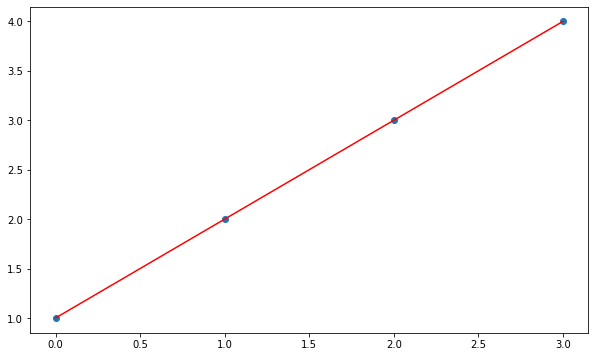

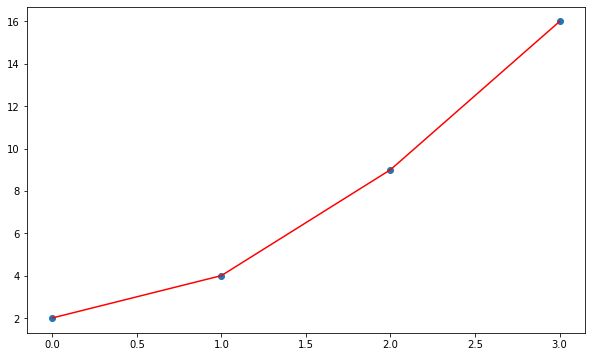

In [16]:
def getRegForChunk(chunk, degree, splits_for_k_val=1, draw=False):
  """
  chunk: a 1D array of data
  degree: a tuple, (min_degree, max_degree)
  draw: draws the generated regression
  """
  X = np.arange(len(chunk)).reshape(-1, 1)

  # compute best degree
  best_score = 10000000
  best_deg = 5
  for d in range(degree[0], degree[1] + 1):
    poly = PolynomialFeatures(degree=d)
    poly_features = poly.fit_transform(X)
    poly_reg_model = linear_model.LinearRegression()

    if splits_for_k_val > 1:
      score = cross_val_score(poly_reg_model, poly_features, chunk, cv=KFold(n_splits=splits_for_k_val, shuffle=True, random_state=1234))
      if score.mean() < best_score:
        best_score = score.mean()
        best_deg = d
    else:
      poly_reg_model.fit(poly_features, chunk)
      y_predicted = poly_reg_model.predict(poly_features)
      r2 = r2_score(chunk, y_predicted)
      if r2 < best_score:
        best_score = r2
        best_deg = d

  # get final model
  poly = PolynomialFeatures(degree=degree[1])
  poly_features = poly.fit_transform(X)
  poly_reg_model = linear_model.LinearRegression()
  poly_reg_model.fit(poly_features, chunk)
  y_predicted = poly_reg_model.predict(poly_features)
  
  if draw:
    plt.figure(figsize=(10, 6))
    plt.scatter(X, chunk)
    plt.plot(X, y_predicted, c='red')
    plt.show()
  
  return y_predicted

def allChunks(chunks, degree, k_val_splits, draw=False):
  ret = []
  for c in chunks:
    ret.append(getRegForChunk(c, degree, splits_for_k_val=k_val_splits, draw=draw))
  return ret

# test
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
size = 4
stride = 3
chunks = chunk(x, size, stride)
y_pred = getRegForChunk(chunks[0], (1, 5), 1, True)

# test
x = [2, 4, 9, 16, 25, 36, 49]
size = 4
stride = 3
chunks = chunk(x, size, stride)
y_pred = getRegForChunk(chunks[0], (1, 5), 1, True)

In [15]:
def getRegression(x, size, stride, degree, k_val_splits=1):
  y = chunk(x, size, stride)
  y = allChunks(y, degree, k_val_splits)
  r = np.array(rebuild(y, size, stride))
  return r

In [17]:
# # Test on hype root: keep size small, otherwise 
# x = dataset['Hype root']
# size = 70
# stride = 55
# degree = (5, 8)

# r = getRegression(x, size, stride, degree)

# discarded = len(x) - np.array(r).shape[0] 
# print("we discarded ", discarded, "initial points")

# # decide which data to visualize:
# inf = 40
# sup = 400

# x_ax = np.arange(sup - inf)
# plt.figure(figsize=(10, 6))
# plt.scatter(x_ax, x[inf + discarded:sup + discarded])
# plt.plot(x_ax, r[inf:sup], c='red')
# plt.show()

def visualize(x, r, inf=40, sup=400):
  discarded = len(x) - np.array(r).shape[0] 
  print("we discarded ", discarded, "initial points")
  x_ax = np.arange(sup - inf)
  plt.figure(figsize=(10, 6))
  plt.scatter(x_ax, x[inf + discarded:sup + discarded])
  plt.plot(x_ax, r[inf:sup], c='red')
  plt.show()

In [18]:
size = 80
stride = 50
degree = (8, 10)

In [19]:
new = {}
for i in dataset:
  new[i] = getRegression(dataset[i], size, stride, degree)
  print(i, "done")

Sponginess done
Wonder level done
Crunchiness done
Loudness on impact done
Meme creativity done
Soap slipperiness done
Hype root done


In [20]:
df = pd.DataFrame.from_dict(new)

we discarded  48 initial points


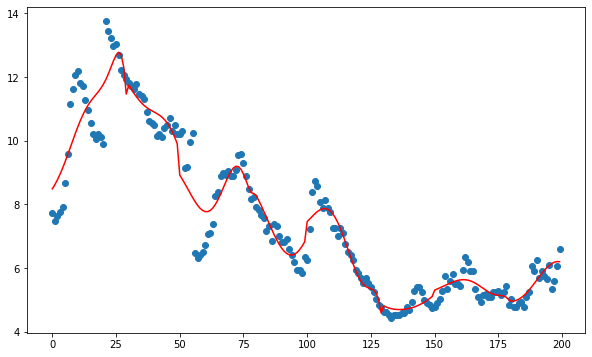

In [24]:
visualize(dataset['Sponginess'], new['Sponginess'], 3000, 3200)

In [22]:
print(df)

       Sponginess  Wonder level  ...  Soap slipperiness  Hype root
0        5.484983      5.713692  ...          31.723626   4.450450
1        5.485001      5.713655  ...          31.723948   4.450430
2        5.485237      5.713199  ...          31.727915   4.450184
3        5.486135      5.711522  ...          31.742346   4.449323
4        5.488279      5.707682  ...          31.775062   4.447453
...           ...           ...  ...                ...        ...
68475    6.438012      6.554601  ...          19.604228  10.885086
68476    6.355171      6.476408  ...          19.574509  11.320258
68477    6.400116      6.513981  ...          19.682385  11.671914
68478    6.695024      6.749372  ...          19.918514  12.048346
68479    7.413610      7.294620  ...          20.250818  12.606655

[68480 rows x 7 columns]


In [23]:
save = True
if save:
  df.to_csv('Training_smooth4.csv', index=False)